# STEP 7: Fit a model

One way to determine if redlining is related to NDVI is to see if we can
correctly predict the redlining grade from the mean NDVI value. With 4
categories, we’d expect to be right only about 25% of the time if we
guessed the redlining grade at random. Any accuracy greater than 25%
indicates that there is a relationship between vegetation health and
redlining.

To start out, we’ll fit a Decision Tree Classifier to the data. A
decision tree is good at splitting data up into squares by setting
thresholds. That makes sense for us here, because we’re looking for
thresholds in the mean NDVI that indicate a particular redlining grade.

First, import variables from previous notebooks:

In [20]:
store -r den_redlining_ndvi_gdf den_ndvi_zstats

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Import packages</div></div><div class="callout-body-container callout-body"><p>The cell below imports some functions and classes from the
<code>scikit-learn</code> package to help you fit and evaluate a
decision tree model on your data. You may need some additional packages
later one. Make sure to import them here.</p></div></div>

In [52]:
import hvplot.pandas
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
import regionmask # Convert shapefile to mask
from xrspatial import zonal_stats # Calculate zonal statistics
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
import numpy as np

As with all models, it is possible to **overfit** our Decision Tree
Classifier by splitting the data into too many disconnected rectangles.
We could theoretically get 100% accuracy this way, but drawing a
rectangle for each individual data point. There are many ways to try to
avoid overfitting. In this case, we can limit the **depth** of the
decision tree to 2. This means we’ll be drawing 4 rectangles, the same
as the number of categories we have.

Alternative methods of limiting overfitting include:

-   Splitting the data into test and train groups – the overfitted model
    is unlikely to fit data it hasn’t seen. In this case, we have
    relatively little data compared to the number of categories, and so
    it is hard to evaluate a test/train split.
-   Pruning the decision tree to maximize accuracy while minimizing
    complexity. `scikit-learn` will do this for you automatically. You
    can also fit the model at a variety of depths, and look for
    diminishing accuracy returns.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Fit a tree model</div></div><div class="callout-body-container callout-body"><p>Replace <code>predictor_variables</code> and
<code>observed_values</code> with the values you want to use in your
model.</p></div></div>

In [23]:
#den_redlining_ndvi_gdf

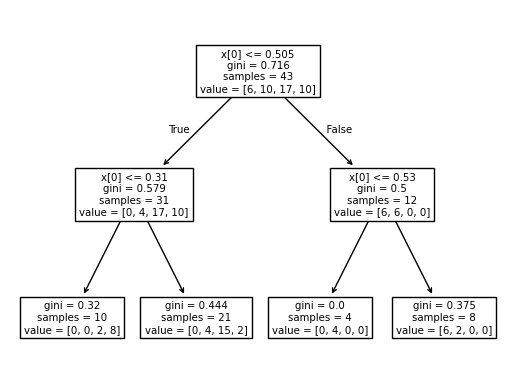

In [46]:
# # Convert categories to numbers
den_redlining_ndvi_gdf['grade_codes'] = (
    den_redlining_ndvi_gdf.grade.cat.codes
)
# Fit model
tree_classifier = DecisionTreeClassifier(max_depth=2).fit(
    #predictor_variables
    den_redlining_ndvi_gdf[['mean']],
    #observed_values
    den_redlining_ndvi_gdf.grade_codes,
)

# Visualize tree
plot_tree(tree_classifier)
plt.show()

In [54]:
den_redlining_ndvi_gdf['predictions']=(
    tree_classifier.predict(den_redlining_ndvi_gdf[['mean']])

)
den_redlining_ndvi_gdf['error']=(
    den_redlining_ndvi_gdf['predictions']
    - den_redlining_ndvi_gdf['grade_codes']
)
#den_redlining_ndvi_gdf['error']
den_redlining_ndvi_gdf.hvplot(c='error', geo=True)

:Polygons   [Longitude,Latitude]   (error)

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Plot model results</div></div><div class="callout-body-container callout-body"><p>Create a plot of the results by:</p>
<ol type="1">
<li>Predict grades for each region using the <code>.predict()</code>
method of your <code>DecisionTreeClassifier</code>.</li>
<li>Subtract the actual grades from the predicted grades</li>
<li>Plot the calculated prediction errors as a chloropleth.</li>
</ol></div></div>

One method of evaluating your model’s accuracy is by cross-validation.
This involves selecting some of your data at random, fitting the model,
and then testing the model on a different group. Cross-validation gives
you a range of potential accuracies using a subset of your data. It also
has a couple of advantages, including:

1.  It’s good at identifying overfitting, because it tests on a
    different set of data than it trains on.
2.  You can use cross-validation on any model, unlike statistics like
    $p$-values and $R^2$ that you may have used in the past.

A disadvantage of cross-validation is that with smaller datasets like
this one, it is easy to end up with splits that are too small to be
meaningful, or don’t have all the categories.

Remember – anything above 25% is better than random!

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Evaluate the model</div></div><div class="callout-body-container callout-body"><p>Use cross-validation with the <code>cross_val_score</code> to
evaluate your model. Start out with the <code>'balanced_accuracy'</code>
scoring method, and 4 cross-validation groups.</p></div></div>

In [55]:
help(cross_val_score)

Help on function cross_val_score in module sklearn.model_selection._validation:

cross_val_score(estimator, X, y=None, *, groups=None, scoring=None, cv=None, n_jobs=None, verbose=0, fit_params=None, params=None, pre_dispatch='2*n_jobs', error_score=nan)
    Evaluate a score by cross-validation.
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    estimator : estimator object implementing 'fit'
        The object to use to fit the data.
    
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        The data to fit. Can be for example a list, or an array.
    
    y : array-like of shape (n_samples,) or (n_samples, n_outputs),             default=None
        The target variable to try to predict in the case of
        supervised learning.
    
    groups : array-like of shape (n_samples,), default=None
        Group labels for the samples used while splitting the dataset into
        train/test set. Only used in conjun

In [58]:
# Evaluate the model with cross-validation
cross_val_score(
    DecisionTreeClassifier(max_depth=2),
     #predictor_variables
    den_redlining_ndvi_gdf[['mean']],
    #observed_values
    den_redlining_ndvi_gdf.grade_codes,
    cv=5
)

array([0.55555556, 0.66666667, 1.        , 0.75      , 0.5       ])

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-extra"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Looking for an Extra Challenge?: Fit and evaluate an alternative model</div></div><div class="callout-body-container callout-body"><p>Try out some other models and/or hyperparameters (e.g. changing the
max_depth). What do you notice?</p></div></div>

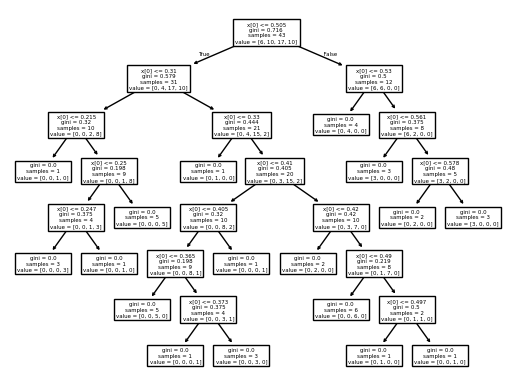

In [59]:
# Try another model

# # Convert categories to numbers
den_redlining_ndvi_gdf['grade_codes'] = (
    den_redlining_ndvi_gdf.grade.cat.codes
)
# Fit model
tree_classifier = DecisionTreeClassifier(random_state=0).fit(
    #predictor_variables
    den_redlining_ndvi_gdf[['mean']],
    #observed_values
    den_redlining_ndvi_gdf.grade_codes,
)

# Visualize tree
plot_tree(tree_classifier)
plt.show()

In [60]:
den_redlining_ndvi_gdf['predictions']=(
    tree_classifier.predict(den_redlining_ndvi_gdf[['mean']])

)
den_redlining_ndvi_gdf['error']=(
    den_redlining_ndvi_gdf['predictions']
    - den_redlining_ndvi_gdf['grade_codes']
)
#den_redlining_ndvi_gdf['error']
den_redlining_ndvi_gdf.hvplot(c='error', geo=True)

:Polygons   [Longitude,Latitude]   (error)

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-respond"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Reflect and Respond</div></div><div class="callout-body-container callout-body"><p>Practice writing about your model. In a few sentences, explain your
methods, including some advantages and disadvantages of the choice.
Then, report back on your results. Does your model indicate that
vegetation health in a neighborhood is related to its redlining
grade?</p></div></div>

# YOUR MODEL DESCRIPTION AND EVALUATION HERE

In [61]:
store den_redlining_ndvi_gdf den_ndvi_zstats

Stored 'den_redlining_ndvi_gdf' (GeoDataFrame)
Stored 'den_ndvi_zstats' (DataFrame)
